# Here I wanna experiment with the training of a simple mlp

In [1]:
# imports
import argparse
import os
import yaml
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from utils import fix_seed, get_device, ensure_dir, save_json, git_hash
from dataloader import TimeSeriesLoader
from models.mlp import STLFMLP

In [4]:
# maybe this can be somewhere else
@torch.no_grad()
def eval_mae_per_target(model, loader, device):
    import numpy as np
    model.eval()
    preds, trues = [], []
    for x, y, _ in loader:
        x = x.to(device).float() 
        y = y.to(device).float()
        preds.append(model(x).cpu().numpy())
        trues.append(y.cpu().numpy())
    P = np.concatenate(preds, 0)
    Y = np.concatenate(trues, 0)
    per_target = np.mean(np.abs(P - Y), axis=0)  # shape (6,)
    return per_target.tolist()


# the main training loop (maybe I can structure this cleaner later)

In [5]:

# train loop
def train_loop(model, train_loader, val_loader, device, cfg, ckpt_dir):
    opt_name = cfg["train"]["optimizer"].lower()
    if opt_name == "adamw":
        opt = torch.optim.AdamW(model.parameters(), lr=cfg["train"]["lr"],
                                weight_decay=cfg["train"]["weight_decay"])
    else:
        opt = torch.optim.Adam(model.parameters(), lr=cfg["train"]["lr"])

    patience = cfg["train"]["early_stopping_patience"]
    best_val = float("inf")
    wait = 0
    history = {"train_loss": [], "val_mae": []}
    os.makedirs(ckpt_dir, exist_ok=True)

    for epoch in range(1, cfg["train"]["epochs"]+1):
        model.train()
        batch_losses = []
        for x, y, flag in train_loader:
            x = x.to(device).float()
            y = y.to(device).float()
            pred = model(x)
            lt = cfg["train"]["loss_type"]
            if lt == "mae":
                loss = (pred - y).abs().mean()
            elif lt == "mse":
                loss = torch.nn.functional.mse_loss(pred, y)
            else:
                loss = torch.nn.functional.huber_loss(pred, y, delta=cfg["train"]["huber_delta"])
            opt.zero_grad(set_to_none=True)
            loss.backward()
            # optional: torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            batch_losses.append(loss.item())

        train_loss = float(np.mean(batch_losses))
        val_mae = eval_mae(model, val_loader, device)

        history["train_loss"].append(train_loss)
        history["val_mae"].append(val_mae)

        improved = val_mae + 1e-9 < best_val
        if improved:
            best_val = val_mae
            wait = 0
            torch.save({"model": model.state_dict()}, os.path.join(ckpt_dir, "best-val.pt"))
        else:
            wait += 1

        print(f"Epoch {epoch:03d} | train_loss {train_loss:.4f} | val_MAE {val_mae:.4f} | best {best_val:.4f} | wait {wait}")
        if patience and wait >= patience:
            print("Early stopping.")
            break

    return best_val, history


Loaded config: mlp_stlf_baseline
0/67
1/67
2/67
3/67
4/67
5/67
6/67
7/67
8/67
9/67
10/67
11/67
12/67
13/67
14/67
15/67
16/67
17/67
18/67
19/67
20/67
21/67
22/67
23/67
24/67
25/67
26/67
27/67
28/67
29/67
30/67
31/67
32/67
33/67
34/67
35/67
36/67
37/67
38/67
39/67
40/67
41/67
42/67
43/67
44/67
45/67
46/67
47/67
48/67
49/67
50/67
51/67
52/67
53/67
54/67
55/67
56/67
57/67
58/67
59/67
60/67
61/67
62/67
63/67
64/67
65/67
66/67
Epoch 001 | train_loss 0.4802 | val_MAE 0.1988 | best 0.1988 | wait 0
Epoch 002 | train_loss 0.2579 | val_MAE 0.2212 | best 0.1988 | wait 1
Epoch 003 | train_loss 0.2217 | val_MAE 0.1483 | best 0.1483 | wait 0
Epoch 004 | train_loss 0.2033 | val_MAE 0.1266 | best 0.1266 | wait 0
Epoch 005 | train_loss 0.1831 | val_MAE 0.1137 | best 0.1137 | wait 0
Epoch 006 | train_loss 0.1766 | val_MAE 0.1111 | best 0.1111 | wait 0
Epoch 007 | train_loss 0.1694 | val_MAE 0.1018 | best 0.1018 | wait 0
Epoch 008 | train_loss 0.1617 | val_MAE 0.1020 | best 0.1018 | wait 1
Epoch 009 | tra

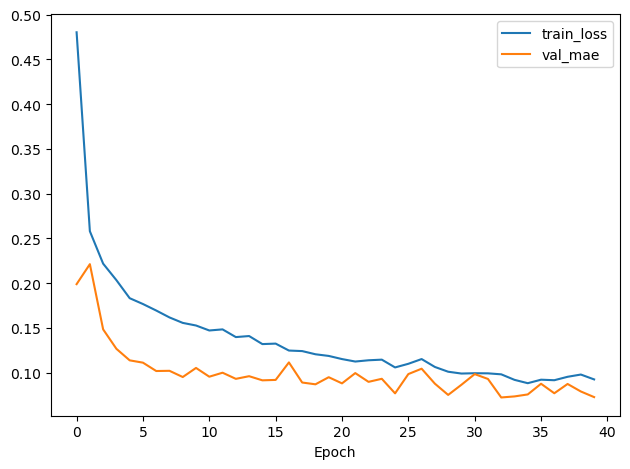

In [6]:
# put this to utils or somewhere else, since loading configs will be used in every model
def load_config(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

# this should be in eval.py or utils.py later and maybe implement different eval strategies and encapsulate them as eval(mae, ...)
@torch.no_grad()
def eval_mae(model, loader, device):
    model.eval()
    preds, trues = [], []
    for x, y, _ in loader:   
        x = x.to(device).float()
        y = y.to(device).float()
        p = model(x)
        preds.append(p.cpu().numpy())
        trues.append(y.cpu().numpy())
    P = np.concatenate(preds, 0)
    Y = np.concatenate(trues, 0)
    return float(np.mean(np.abs(P - Y)))

# this is the real training loop
def main(cfg_path):
    cfg = load_config(cfg_path)
    print("Loaded config:", cfg["exp_name"])
    fix_seed(cfg["seed"], deterministic=True) # we want to use a fixed seed and a deterministic algorithm to ensure reproducibility
    device = get_device(cfg["device"])

    # trying to use the dataloader as it is used in the benchmark for comparability (implement another dataloader later for performance)
    loader = TimeSeriesLoader(task='forecasting', root=cfg["data"]["root"])

    # train loader full will be used as it is but we need an evaluation set and therefore split the test set
    train_loader_full, test_loader = loader.load(
        batch_size=cfg["data"]["batch_size"],
        shuffle=cfg["data"]["shuffle"]  
    )  

    # split a val from training set (makeing sure it is chronological)
    full_ds = train_loader_full.dataset
    N = len(full_ds)
    val_len = int(N * cfg["data"]["val_ratio"])
    train_len = N - val_len
    train_idx = list(range(0, train_len))
    val_idx   = list(range(train_len, N))

    # optional : num_workers or pin_memory in config to increase training (only use if enough RAM and training is too slow)
    train_loader = DataLoader(Subset(full_ds, train_idx),
                              batch_size=cfg["data"]["batch_size"],
                              shuffle=cfg["data"]["shuffle"],
                              drop_last=False)
    val_loader   = DataLoader(Subset(full_ds, val_idx),
                              batch_size=cfg["data"]["batch_size"],
                              shuffle=False,
                              drop_last=False)

    # the model architecture
    model = STLFMLP(
        input_dim=cfg["model"]["input_dim"],
        hidden_sizes=cfg["model"]["hidden_sizes"],
        out_dim=cfg["model"]["out_dim"],
        dropout=cfg["model"]["dropout"],
        use_layernorm=cfg["model"]["use_layernorm"],
        use_input_norm=cfg["model"]["use_input_norm"],
        activation=cfg["model"]["activation"],
    ).to(device)

    # using this only for training data to improve training but NEVER on val or test, input normalizer active is prob always the best option so I remains active
    model.fit_input_normalizer_from_loader(train_loader)

    # training loop and checkpoint to save the best model
    exp_dir  = os.path.join(cfg["out"]["dir"], cfg["exp_name"])
    ckpt_dir = os.path.join(exp_dir, "checkpoints")
    ensure_dir(exp_dir)
    best_val, history = train_loop(model, train_loader, val_loader, device, cfg, ckpt_dir)

    # laod the best model and not the last one
    ckpt = torch.load(os.path.join(ckpt_dir, "best-val.pt"), map_location=device)
    model.load_state_dict(ckpt["model"])

    model.eval()
    ids_all, preds_all = [], []
    with torch.no_grad():
        for ID, x in test_loader:
            x = x.to(device).float()
            p = model(x).cpu().numpy()
            ids_all.append(ID.cpu().numpy())
            preds_all.append(p)

    IDs = np.concatenate(ids_all, 0)
    P   = np.concatenate(preds_all, 0)

    cols = ["yl_t+60","yl_t+1440","yw_t+5","yw_t+30","ys_t+5","ys_t+30"]
    preds_df = pd.DataFrame(P, columns=cols)
    preds_df.insert(0, "ID", IDs)
    preds_df.to_csv(os.path.join(exp_dir, "preds.csv"), index=False)
    print("saved test predictions:", os.path.join(exp_dir, "preds.csv"))

    # collect meta data
    meta = {
        "git_hash": git_hash(),
        "config": cfg,
        "best_val_mae": best_val,
        "n_train": len(train_idx),
        "n_val": len(val_idx),
        "history": history,
    }
    save_json(os.path.join(exp_dir, "metrics.json"), meta)

    plt.figure()
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_mae"], label="val_mae")
    plt.xlabel("Epoch")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(exp_dir, "learning_curve.png"))

    per_target = eval_mae_per_target(model, val_loader, device)
    print("Val-MAE per target:", per_target)

    print("done. artifacts in:", exp_dir)


def parse_args():
    ap = argparse.ArgumentParser()
    ap.add_argument("--config", type=str, default="../configs/mlp.yaml")
    # use Jupyter args:
    known, _ = ap.parse_known_args()
    return known

if __name__ == "__main__":
    args = parse_args()
    main(args.config)